## CIS 519 Group Project -  EfficientNet Implementation

### Library Imports

In [1]:
!pip install timm # install PyTorch Image Models

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils import data
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim 
from tqdm.notebook import tqdm
import timm
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

### Helper Functions

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

### Parameter Initialization

In [4]:
class config_params:
    epochs = 10                            # No. of epochs for training the model
    lr = 0.001                             # Learning rate
    batch_size = 16                        # Batch Size for Dataset
    img_size = 224                         # Resize all the images to be 224 by 224   
    in_channels = 3                        # No of channels in input image
    num_classes = 6                        # No. of classes
    model_name = 'efficientnet_b0'         # Model Used

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


### Data Loading

In [5]:
#read the data from the folder
data_dir = './dataset'
classes = os.listdir(data_dir)

In [6]:
#Data Transforms to apply on the Images

train_transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [7]:
dataset = ImageFolder(data_dir, transform=transform)
print('Size of the dataset :', len(dataset))

Size of the dataset : 58954


In [8]:
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [9]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  BreastMRI (1)


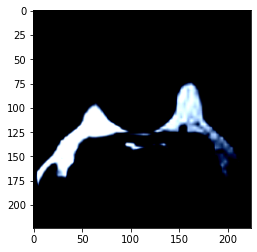

In [10]:
show_image(*dataset[10001])

In [11]:
#class to split the data and apply transformations

Labels = {'AbdomenCT':0, 'BreastMRI':1,'CXR':2,'ChestCT':3,'Hand':4,'HeadCT':5}

class MedicalMNIST(data.Dataset):
    
 
    def __init__(self, root, transforms=None, train=True, test=False, val = False):
        """
        Main objective: to obtain the addresses of all pictures and divide the data according to training, verification and test
        """
        self.test = test
        self.val = val
        self.transforms = transforms
 
        if self.test:
            imgs = [os.path.join(root, img) for img in os.listdir(root)]
            self.imgs = imgs
        else:
            imgs_labels = [os.path.join(root, img) for img in os.listdir(root)]
            imgs = []
            for imglable in imgs_labels:
                for imgname in os.listdir(imglable):
                    imgpath = os.path.join(imglable, imgname)
                    imgs.append(imgpath)
                    
            torch.manual_seed(20)
            val_size = int(round(len(dataset) * 0.2, 0))
            test_size = int(round(len(dataset) * 0.1, 0))
            train_size = len(dataset) - val_size - test_size
            train_ds, val_ds, test_ds = random_split(imgs, [train_size, val_size, test_size])
            
            #trainval_files, te_files = train_test_split(imgs, test_size=0.3, random_state=42)
            if train == True:
                self.imgs = train_ds
            elif val == True:
                self.imgs = val_ds
            else:
                self.imgs = test_ds
 
    def __getitem__(self, index):
        """
        Returns the data of one picture at a time
        """
        img_path = self.imgs[index]
        img_path=img_path.replace("\\",'/')
        if self.test:
            label = -1
        else:
            
            labelname = img_path.split('/')[-2]
            
            label = Labels[labelname]
           
        data = Image.open(img_path).convert('RGB')
        data = self.transforms(data)
        return data, label
 

    def __len__(self):
        return len(self.imgs)

In [12]:
# Split the data
batch_size = config_params.batch_size
dataset_train = MedicalMNIST(data_dir, transforms=train_transform, train=True)
dataset_val = MedicalMNIST(data_dir, transforms=transform, train=False,val=True)
dataset_test = MedicalMNIST(data_dir,transforms=test_transform, train=False)

# Import data into Dataloader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size= batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size= batch_size, shuffle=False)

In [13]:
print("No. of batches in trainloader:{}".format(len(train_loader))) 
print("No. of Total examples:{}".format(len(train_loader.dataset)))

No. of batches in trainloader:2580
No. of Total examples:41268


In [14]:
print("No. of batches in validationloader:{}".format(len(val_loader)))  
print("No. of Total examples:{}".format(len(val_loader.dataset)))

No. of batches in validationloader:737
No. of Total examples:11791


In [17]:
print("No. of batches in testloader:{}".format(len(test_loader)))

No. of batches in testloader:369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


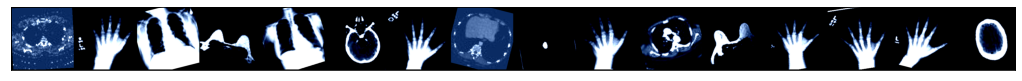

In [18]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

### Model Definition

In [19]:
#Instantiate the model

model = timm.create_model(config_params.model_name,pretrained=True) #load pretrained model

In [20]:
print(model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   

In [21]:
#define the model architecture

for param in model.parameters():
    param.requires_grad=False


model.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=256), #1280 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=256, out_features= config_params.num_classes), 
)

model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   

### Training and Testing

In [23]:
#Model Trainining and Testing
class Trainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    #train loop
    def train_batch_loop(self,model,train_loader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(train_loader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
            
         #return average loss and accuracy    
        return train_loss / len(train_loader), train_acc / len(train_loader) 

    #validation loop
    def valid_batch_loop(self,model,val_loader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(val_loader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
        
        #return average loss and accuracy        
        return valid_loss / len(val_loader), valid_acc / len(val_loader)
    
    #test loop
    def test_batch_loop(self,model,test_loader):
        y_pred = []
        y_true = []
        test_loss = 0.0
        test_acc = 0.0

        # iterate over test data
        for inputs, labels in test_loader:
                inputs = inputs.to(device) 
                labels = labels.to(device)
            
                output = model(inputs) # Feed Network
                
                loss = self.criterion(output,labels)
                
                test_loss += loss.item()
                test_acc += accuracy(output,labels)
            
                
                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction

                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

        #return labels, predictions, average loss and accuracy
        return y_true, y_pred, test_loss / len(test_loader), test_acc / len(test_loader)
            
    #fit function   
    def fit(self,model,train_loader,valid_loader,epochs):
        train_loss, validation_loss = [], []
        train_acc, validation_acc = [], []
       
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,train_loader) ###
            train_loss.append(avg_train_loss)  # append the loss for this epoch
            train_acc.append(avg_train_acc)
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,valid_loader) ###
            
            validation_loss.append(avg_valid_loss)
            validation_acc.append(avg_valid_acc)
            
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))
       
        return train_loss, train_acc, validation_loss, validation_acc 

In [24]:
in_channels = config_params.in_channels
num_classes = config_params.num_classes
lr = config_params.lr
epochs = config_params.epochs


model.to(device) # move the model to GPU 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr)

trainer = Trainer(criterion,optimizer)
train_loss, train_acc, validation_loss, validation_acc = trainer.fit(model,train_loader,val_loader,epochs)

  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 1 Train Loss : 0.029776 Train Acc : 0.991085
Epoch : 1 Valid Loss : 0.003629 Valid Acc : 0.999152


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.016221 Train Acc : 0.995446
Epoch : 2 Valid Loss : 0.020081 Valid Acc : 0.993470


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.009543 Train Acc : 0.996972
Epoch : 3 Valid Loss : 0.000035 Valid Acc : 1.000000


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.009455 Train Acc : 0.997214
Epoch : 4 Valid Loss : 0.000247 Valid Acc : 0.999915


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.008405 Train Acc : 0.997965
Epoch : 5 Valid Loss : 0.000252 Valid Acc : 0.999830


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.008121 Train Acc : 0.997917
Epoch : 6 Valid Loss : 0.000423 Valid Acc : 0.999830


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.011203 Train Acc : 0.997771
Epoch : 7 Valid Loss : 0.000545 Valid Acc : 0.999661


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.009107 Train Acc : 0.997820
Epoch : 8 Valid Loss : 0.007801 Valid Acc : 0.998558


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.009623 Train Acc : 0.998014
Epoch : 9 Valid Loss : 0.000619 Valid Acc : 0.999746


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.007319 Train Acc : 0.998110
Epoch : 10 Valid Loss : 0.003305 Valid Acc : 0.998982


In [25]:
#Testing the Model on test samples

model.eval()
true, pred , avg_test_loss, avg_test_acc = trainer.test_batch_loop(model,test_loader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

Test Loss : 0.0018292106409226849
Test Acc : 0.9994918704032898


### Result Visualisations

Confusion Matrix for CoAt Net


[[ 955    0    0    0    0    0]
 [   0  919    0    0    0    0]
 [   0    0  983    0    0    0]
 [   0    0    0 1017    0    0]
 [   0    3    0    0 1029    0]
 [   0    0    0    0    0  989]]


<AxesSubplot:>

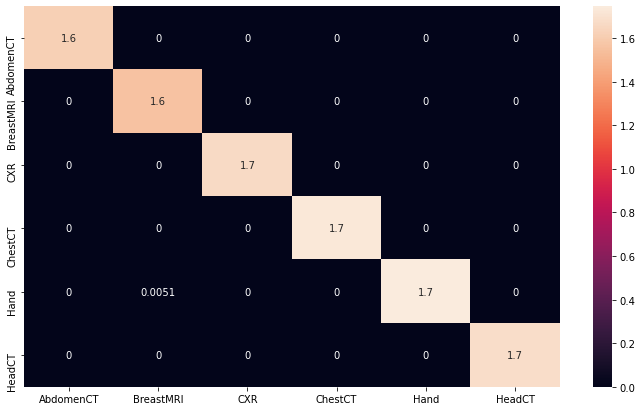

In [28]:
# labels for classes
classes = ['AbdomenCT', 'BreastMRI','CXR','ChestCT','Hand','HeadCT']

# Build confusion matrix
cf_matrix = confusion_matrix(true, pred)
print("Confusion Matrix for CoAt Net")
print("\n")
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))

#Class- wise predictions
sns.heatmap(df_cm, annot=True)

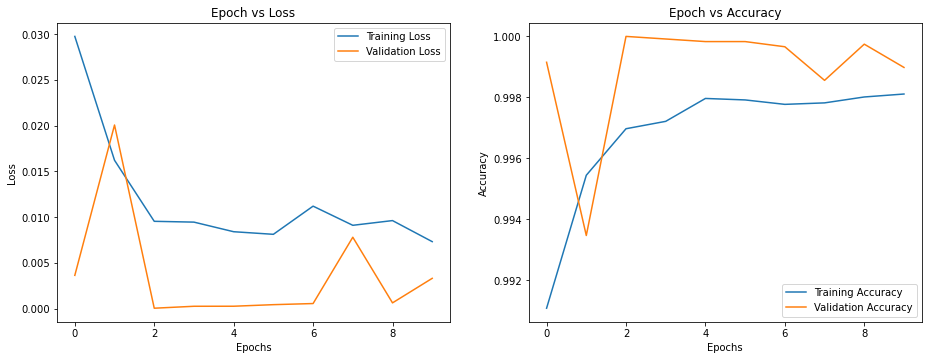

In [27]:
#Plot of accuracy and loss 

plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)